In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [2]:
import matplotlib.pyplot as plt
import imblearn
import random
import seaborn as sns 
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score,make_scorer,confusion_matrix,ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier,NeighborhoodComponentsAnalysis
from xgboost import XGBClassifier

In [3]:
#setting random seed for reproducability:
rs=7
random.seed(rs)
np.random.seed(rs)

In [4]:
df=pd.read_csv('../input/creditcardfraud/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
#info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:

df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


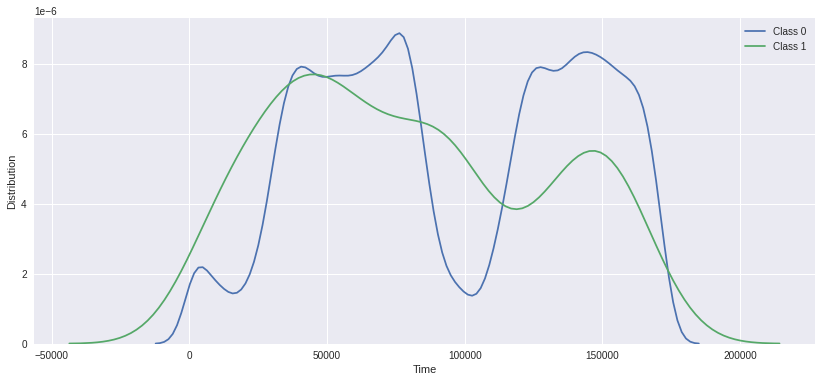

In [7]:
#lets plot the distributions of continous variables that make sense(i.e Time and Amount).
plt.style.use('seaborn')
def Dist(df,col):
    fig,ax=plt.subplots(figsize=(14,6))
    for key,grp in df.groupby('Class'):
        sns.distplot(grp[col],hist=False,ax=ax,label=f'Class {key}')
    plt.xlabel(col)
    plt.ylabel('Distribution')
    plt.legend()
    plt.show()

Dist(df,'Time')    

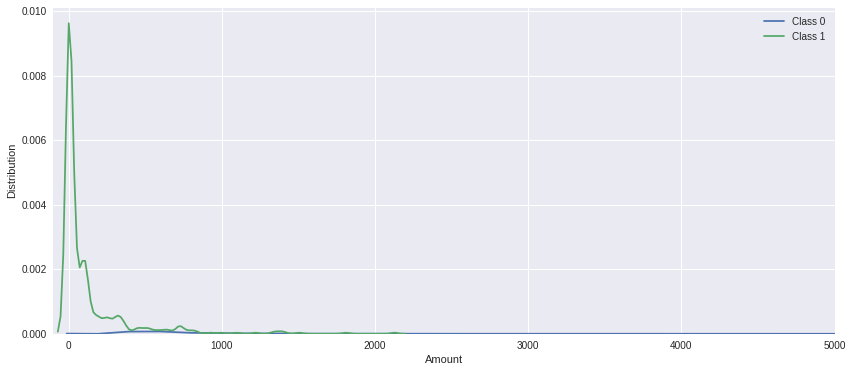

In [8]:
fig,ax=plt.subplots(figsize=(14,6))
for key,grp in df.groupby('Class'):
    sns.distplot(grp['Amount'],hist=False,ax=ax,label=f'Class {key}')
plt.xlabel('Amount')
plt.ylabel('Distribution')
plt.xlim(-100,5000)
plt.legend()
plt.show()

In [9]:

#lets see what the mean fraud amount is.
mean_fraud_amount=df[df['Class']==1]['Amount'].mean()
mean_fraud_amount


122.21132113821133

In [10]:
#lets check the class balance.
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

There is a heavy imbalance in the class.This will most likely cause a inflated accuracy score(because the model will classify most instances as a 0 and still achive a high accuracy.).So we will train the model with the normal data and check the F1 score and confusion matrix and then oversample the minority class(i.e 1's) and then train the model.

In [11]:
#Features.
X=df.drop('Class',axis=1)
#target variable
y=df['Class']

In [12]:
#splitting train and test data .
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2,random_state=rs,stratify=y)

#Normalizing the data.
minmax=MinMaxScaler()

X_train=minmax.fit_transform(X_train)
X_test=minmax.transform(X_test)

In [13]:
#using pca to reduce dimensionality of the data .

from sklearn.decomposition import PCA
pca=PCA(n_components=10)
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test)
X_train.shape

(227845, 10)

In [14]:
#use f1 scorer as an alternative evaluation metric. 
f1_scorer=make_scorer(f1_score)

In [15]:
#Models
Lr=LogisticRegression()
Rfc=RandomForestClassifier(n_estimators=30,random_state=7,n_jobs=-1)
Xgbc=XGBClassifier(n_estimators=30,random_state=7,n_jobs=-1)

# nca = NeighborhoodComponentsAnalysis(random_state=7)
knn = KNeighborsClassifier(n_neighbors=5)
# nca_pipe = Pipeline([('nca', nca), ('knn', knn)])

#Stratified K fold
Skfold=StratifiedKFold(random_state=7,n_splits=5,shuffle=True)

models=[Lr,knn,Rfc,Xgbc]

In [16]:
Xgbc.fit(X_train,y_train)
pred=Xgbc.predict(X_test)
cm=confusion_matrix(pred,y_test,labels=Xgbc.classes_)
Score=Xgbc.score(X_test,y_test)
print(f'score without oversampling is {Score}')
# ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=knn.classes_).plot()


score without oversampling is 0.999420666409185


Although the score seems to be extraodinarily good, it is so because of the heavy class imbalance.

In [17]:
print('Confusion Matrix')
cm

Confusion Matrix


array([[56861,    30],
       [    3,    68]])

The model has predicted 68 instances of fraud correctly, while it has missed 30 instances. It has wrongly classified 3 instances as fraud.

In [18]:
#feature importance.
import eli5
from eli5.sklearn import PermutationImportance
perm=PermutationImportance(Xgbc,random_state=7).fit(X_test,y_test)
eli5.show_weights(perm)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Weight,Feature
0.0012 ± 0.0001,x8
0.0005 ± 0.0002,x7
0.0004 ± 0.0001,x9
0.0001 ± 0.0001,x6
0.0001 ± 0.0001,x4
0.0000 ± 0.0000,x5
0.0000 ± 0.0001,x1
0.0000 ± 0.0000,x2
0.0000 ± 0.0000,x3
0.0000 ± 0.0000,x0


In [19]:
# Crossval scores:
# for model in models:
#     acc=cross_val_score(model,X_train,y_train,cv=Skfold,scoring=f1_scorer)
#     print(f'Mean f1 score with {model} is {acc.mean()} +/- {acc.std()}')


#skipping this part because the dataset is big and it takes significant time to train.

In [20]:


# from sklearn.model_selection import learning_curve

# #lets plot a learning curve.

# def plot_learning_curve(estimator,X,y,train_sizes,scoring,cv=5):
#     train_sizes,train_scores,valid_scores=learning_curve(
#     estimator=estimator,
#     X=X,y=y,
#     cv=cv,scoring=f1_scorer)

#     #calc mean cv score and plotting.
#     mean_training_scores=train_scores.mean(axis=1)
#     mean_valid_scores=valid_scores.mean(axis=1)
#     plt.figure(figsize=(16,10))
#     plt.plot(train_sizes,mean_training_scores,label='training_score')
#     plt.plot(train_sizes,mean_valid_scores,label='Validation score')
#     plt.xlabel('training set size')
#     plt.ylabel('f1 score')
#     plt.legend()
#     plt.title('Learning curve for XGB Classifier')
#     plt.show()

In [21]:
# train_sizes=[round(len(X_train)/8),round(len(X_train)/4),round(len(X_train)/2),len(X)]

# plot_learning_curve(estimator=Lr,X=X_train,y=y_train, train_sizes=train_sizes, scoring=f1_scorer,cv=Skfold)

# Over Sampling using SMOTE(Synthetic Minority Oversampling Technique).

Now lets improve the class imbalance by over sampling the data with the minority class(i.e 1's).

In [22]:
#splitting train and test data .
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2,random_state=7,stratify=y)

In [23]:
#over sampling using SMOTE
smote=imblearn.over_sampling.SMOTE()
print('before SMOTE \n'  , y_train.value_counts())

X_smote,y_smote=smote.fit_resample(X_train,y_train)
print('After SMOTE \n',y_smote.value_counts())

before SMOTE 
 0    227451
1       394
Name: Class, dtype: int64
After SMOTE 
 1    227451
0    227451
Name: Class, dtype: int64


In [24]:
#Normalizing the data.
minmax=MinMaxScaler()

X_smote=minmax.fit_transform(X_smote)
X_test=minmax.transform(X_test)


In [25]:
#dimensionality reduction.
from sklearn.decomposition import PCA 
pca=PCA(n_components=10)
X_smote=pca.fit_transform(X_smote)
X_test=pca.transform(X_test)

In [26]:
Xgbc.fit(X_smote,y_smote)
cm=confusion_matrix(Xgbc.predict(X_test),y_test,labels=Xgbc.classes_)
Score=Xgbc.score(X_test,y_test)
print(f'Score using SMOTE is {Score}')

# ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=knn.classes_).plot()


Score using SMOTE is 0.995031775569678


The score is still un-reliable as we have heavy class imbalance in the test set which is driving the score up.

In [27]:
print('Confusion Matrix')
cm

Confusion Matrix


array([[56596,    15],
       [  268,    83]])

The model is now correctly identifying 83 instances of fraud, while it is missing 15 instances. It is wrongly classifying 268 instances of not-fraud as fraud. The oversampling is giving a better result in terms of detecting fraud, but at the cost of wrongly classifying some examples.

# Oversampling using SMOTE + ENN.


In [28]:
#splitting train and test data .
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2,random_state=7,stratify=y)

In [29]:
#SMOTE + ENN:
smoteenn=imblearn.combine.SMOTEENN()
print('Before SMOTEENN \n', y_train.value_counts())

X_smoteenn,y_smoteenn=smoteenn.fit_resample(X_train,y_train)
print('After \n', y_smoteenn.value_counts())

Before SMOTEENN 
 0    227451
1       394
Name: Class, dtype: int64
After 
 1    219604
0    210705
Name: Class, dtype: int64


In [30]:
#Normalizing the data.
minmax=MinMaxScaler()

X_smoteenn=minmax.fit_transform(X_smoteenn)
X_test=minmax.transform(X_test)

In [31]:
#dimensionality reduction.
X_smoteenn=pca.fit_transform(X_smoteenn)
X_test=pca.transform(X_test)

In [32]:
Xgbc.fit(X_smoteenn,y_smoteenn)
pred=Xgbc.predict(X_test)
cm=confusion_matrix(pred,y_test)
score=Xgbc.score(X_test,y_test)
print(f'Score using SMOTEENN is {score}')


Score using SMOTEENN is 0.9947157754292335


In [33]:
print('Confusion Matrix')
cm

Confusion Matrix


array([[56578,    15],
       [  286,    83]])

Similar to using SMOTE, using SMOTEENN has resulted in correct classification of 83 instances of fraud,has missed 15 instances and wrongly classified 286 instances as fraud. Thus with oversampling, the probablity of detecting a fraud increases, but it also classifying some examples incorrectly.